In [1]:
"""
Load initially trained network and run adaptation experiment.
"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.serialization
import sklearn
from collections import OrderedDict
from modeldef import RNN,test
import os
from pathlib import Path


In [2]:
torch.cuda.is_available()

True

/tmp/ipykernel_2450213/1024126597.py:147: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  state_dict['output.weight'] = dtype(rotmat) @ \
/home/jawad/.conda/envs/feedback_plasticity/lib/python3.12/site-packages/torch/utils/_device.py:104: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  return func(*args, **kwargs)


Epoch=0 | Loss=1.4131
Epoch=1 | Loss=1.6866
Epoch=2 | Loss=2.0102
Epoch=3 | Loss=1.5220
Epoch=4 | Loss=2.1285
Epoch=5 | Loss=1.3416
Epoch=6 | Loss=1.7900
Epoch=7 | Loss=2.0467
Epoch=8 | Loss=2.1799
Epoch=9 | Loss=1.5851
Epoch=10 | Loss=1.7707
Epoch=11 | Loss=1.3257
Epoch=12 | Loss=1.6867
Epoch=13 | Loss=1.4913
Epoch=14 | Loss=1.2599
Epoch=15 | Loss=1.6824
Epoch=16 | Loss=1.6097
Epoch=17 | Loss=1.3179
Epoch=18 | Loss=1.8211
Epoch=19 | Loss=1.9432
Epoch=20 | Loss=1.1268
Epoch=21 | Loss=1.7275
Epoch=22 | Loss=1.5226
Epoch=23 | Loss=1.5272
Epoch=24 | Loss=1.2780
Epoch=25 | Loss=1.3638
Epoch=26 | Loss=1.2442
Epoch=27 | Loss=1.4623
Epoch=28 | Loss=1.5975
Epoch=29 | Loss=1.1699
Epoch=30 | Loss=1.3946
Epoch=31 | Loss=1.5268
Epoch=32 | Loss=1.3509
Epoch=33 | Loss=1.4660
Epoch=34 | Loss=1.3289
Epoch=35 | Loss=1.6395
Epoch=36 | Loss=1.4247
Epoch=37 | Loss=1.5498
Epoch=38 | Loss=1.2932
Epoch=39 | Loss=1.2821
Epoch=40 | Loss=1.5733
Epoch=41 | Loss=1.5634
Epoch=42 | Loss=1.5521
Epoch=43 | Loss=1.657

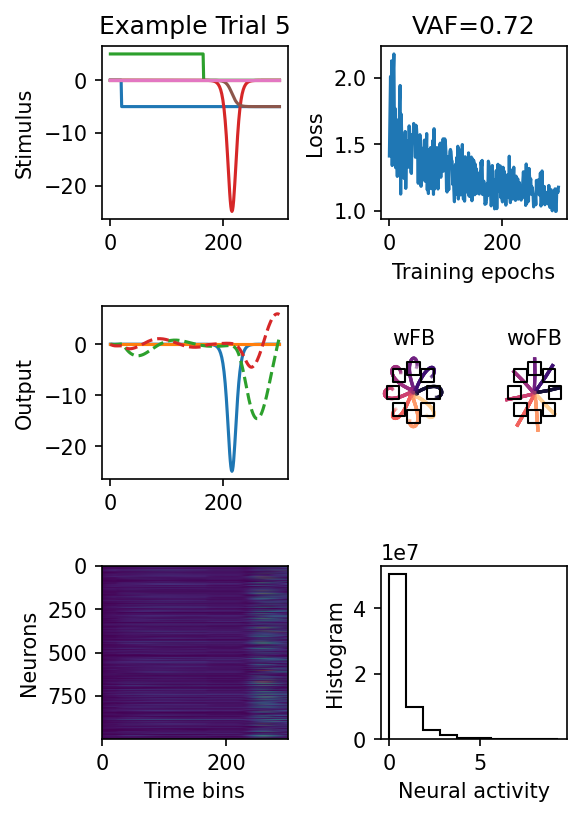

In [3]:
def main(name='test',backprop=False, control=False, single_target=False,
             popto=False, popto_param=None, rot_sd=0):
    
    # LOAD PARAMETERS ###################
    directory = Path.cwd() / 'results'
    name = name
    savname = directory / name
    dataT = torch.load(savname / 'phase3_training', weights_only= False)
    data = np.load(savname / 'data.npy',allow_pickle=True).item()['center-out-reach']
    params = np.load(savname / 'params.npy',allow_pickle=True).item()
 
    # ADAPTATION PARAMETERS #############
    if not backprop:
        lr = 1e-7
        batch_size = 1
        if control:
            ntrials = 210
        elif popto:
            ntrials = 100
        elif rot_sd != 0:
            ntrials = 160
        else:
            ntrials = 300
    else:
        lr = 5e-7
        ntrials = 100
        batch_size = params['model']['batch_size']
        
        
    if directory!=params['directory'] or name!=params['name']:
        print('Naming is inconsistent!')
        return 0 
    
    if not control:
        if single_target:
            savname = savname / 'AD_singletarget'
        elif popto:
            savname = savname / 'AD_popto_'+popto_param['name']
        elif rot_sd!=0:
            savname = savname / ('AD_rotsd%d'%rot_sd)
        else:
            savname = savname / 'AD'
    else:
        savname += 'AD_ctrl/'
        
    if not os.path.exists(savname):
        os.mkdir(savname)
    else:
        print('There is already an adaptation simulation!')
        return 0
    
    # SETUP SIMULATION #################
    rand_seed = params['model']['rand_seed']
    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    
    # GPU usage 
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        torch.set_default_device('cuda')
    else:
        dtype = torch.FloatTensor
        torch.set_default_device('cpu')
   
    # SETUP MODEL #################
    model = RNN(params['model']['input_dim'],
                params['model']['output_dim'],
                params['model']['n'],
                params['model']['dt']/params['model']['tau'],
                dtype,
                params['model']['dt'],
                params['model']['fwd_delay'],
                params['model']['fb_delay'],
                fb_sparsity=params['model']['fb_sparsity'],
                nonlin=params['model']['nonlin'],
                noiseout=params['model']['noise_amp'],
                noise_kernel_size=params['model']['noise_kernel_size'],
                noisein=params['model']['noise_stim_amp'],
                rec_sparsity=params['model']['rec_sparsity'])
    
    model.load_state_dict(dataT['model_state_dict'])
    
    # set some weights static
    model.output.weight.requires_grad = False 
    model.output.bias.requires_grad = False 
    model.rnn.weight_ih_l0.requires_grad = False
    # model.rnn.weight_hh_l0.requires_grad = False
    model.feedback.weight.requires_grad = False
    model.feedback.bias.requires_grad = False

    # SETUP OPTIMIZER #################
    criterion = nn.MSELoss(reduction='none') 
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr) 
    
    # SET UP DATA ######################
    tout = data['target'][:,:,2:]
    tstim = data['stimulus']
    tid = data['tids']
    goes = data['peak_speed']-params['data']['go_to_peak']

    # single target adaptation
    if single_target:
        mask = tid==0
        tout = tout[mask]
        tstim = tstim[mask]
        tid = tid[mask]
        goes = goes[mask]

    # convert to pytorch form
    target = torch.zeros(ntrials, params['model']['tsteps'], 
        batch_size, params['model']['output_dim']).type(dtype)
    stimulus = torch.zeros(ntrials, params['model']['tsteps'], 
        batch_size, tstim.shape[-1]).type(dtype)
    pert = torch.zeros(ntrials, params['model']['tsteps'], 
        batch_size, params['model']['output_dim']).type(dtype)
    if popto:
        popto_act = np.zeros((ntrials,params['model']['tsteps'],params['model']['n']))
    tids = []
    for j in range(ntrials):
        idx = np.random.choice(range(tout.shape[0]),batch_size,
                               replace=False)
        target[j] = torch.Tensor(tout[idx].transpose(1,0,2)).type(dtype)
        stimulus[j] = torch.Tensor(tstim[idx].transpose(1,0,2)).type(dtype)
        tids.append([tid[idx[0]],goes[idx[0]]])
        if popto:
            # create perturbation input
            if j>popto_param['fromto'] and j<popto_param['upto'] and np.random.rand()<0.5:
                at = goes[idx[0]] 
                if popto_param['name']=='cue':
                    popto_act[j,20:40,:popto_param['Npert']] = popto_param['pamp'] 
                else:
                    popto_act[j,
                        (at+popto_param['go_bef']):(at+popto_param['go_aft']),
                        :popto_param['Npert']] = popto_param['pamp']
    if popto:
        perturbed = np.sum(popto_act,axis=(1,2))>0
        popto_act = torch.Tensor(popto_act).type(dtype)

    # SET UP PERTURBATION ################
    # visuomotor rotation
    rot_phi = params['model']['rot_phi']
    rotmat = np.array([[np.cos(rot_phi),-np.sin(rot_phi)],
                       [np.sin(rot_phi),np.cos(rot_phi)]])
    state_dict = model.state_dict()
    save_state_dict = state_dict['output.weight'].detach().clone()
    state_dict['output.weight'] = dtype(rotmat) @ \
                                state_dict['output.weight']
    model.load_state_dict(state_dict, strict=True)
    
    # START ADAPTATION #################
    lc = []
    model.train()
    if not control and not backprop:
        model.biolearning = True
    outs = []
    hids = []
    errs = []
    rot_phi = np.random.randn(ntrials)*rot_sd/180*np.pi+params['model']['rot_phi']
    for epoch in range(ntrials): 
        # add rotation variability
        if rot_sd!=0:
            rotmat = np.array([[np.cos(rot_phi[epoch]),-np.sin(rot_phi[epoch])],
                               [np.sin(rot_phi[epoch]),np.cos(rot_phi[epoch])]])
            state_dict['output.weight'] = dtype(rotmat) @ \
                                        save_state_dict.clone()
            model.load_state_dict(state_dict, strict=True)
        toprint = OrderedDict()
        optimizer.zero_grad()
        if not backprop:
            if popto:
                output,hidden = model(stimulus[epoch],pert[epoch],lr,popto_act[epoch])
            else:
                output,hidden = model(stimulus[epoch],pert[epoch],lr)
        else:
            if popto:
                output,hidden = model(stimulus[epoch],pert[epoch],popto=popto_act[epoch])
            else:
                output,hidden = model(stimulus[epoch],pert[epoch])
                
        loss_train = criterion(output, output*0).mean()
        toprint['Loss'] = loss_train
        train_running_loss = loss_train.detach().item()
        print(('Epoch=%d | '%(epoch)) +" | ".join("%s=%.4f"%(k, v) for k, v in toprint.items()))
        lc.append(train_running_loss)   
        if not backprop:
            testout = model.get_output(hidden)
            outs.append(testout.cpu().detach().numpy().transpose(1,0,2))
            hids.append(hidden.cpu().detach().numpy().transpose(1,0,2))
            errs.append(output.cpu().detach().numpy().transpose(1,0,2))
        else:
            # select one from the batch and save it
            testout = model.get_output(hidden)
            outs.append(testout.cpu().detach().numpy().transpose(1,0,2)[0])
            # add regularization
            # term 1: parameters
            regin = params['model']['alpha1']*model.rnn.weight_ih_l0.norm(2)
            regout = params['model']['alpha1']*model.output.weight.norm(2)
            regoutb = params['model']['alpha1']*model.output.bias.norm(2)
            regfb = params['model']['alpha1']*model.feedback.weight.norm(2)
            regfbb = params['model']['alpha1']*model.feedback.bias.norm(2)
            regrec = params['model']['gamma1']*model.rnn.weight_hh_l0.norm(2)
            toprint['In'] = regin
            toprint['Rec'] = regrec
            toprint['Out'] = regout
            toprint['OutB'] = regoutb
            toprint['Fb'] = regfb
            toprint['FbB'] = regfbb
            # term 2: rates
            regact = params['model']['beta1']*hidden.pow(2).mean() 
            toprint['Act'] = regact
         
            loss = loss_train+regin+regrec+regout+regoutb+regact+regfbb+regfb
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                           params['model']['clipgrad'])
            optimizer.step()
    # test it
    model.eval()
    model.biolearning = False
    # save
    if not backprop:
        torch.save({
                    'tid':np.array(tids),
                    'stimulus':stimulus.cpu().detach().numpy()[:,:,0,:],
                    'target':target.cpu().detach().numpy()[:,:,0,:],
                    'outs':np.array(outs)[:,0],
                    'hids':np.array(hids)[:,0],
                    'errs':np.array(errs)[:,0],
                    'batch_size':batch_size,
                    'lr':lr,
                    'epoch': ntrials,
                    'model_state_dict': model.state_dict(),
                    'lc':np.array(lc),
                    'params':params,
                    'popto_param':popto_param,
                    'popto_perturbed':perturbed if popto else 0,
                    'rot_phi':rot_phi
                    }, savname / 'phase_training')#+'_'+str(popto_param['Npert'])+
                                                # '_'+str(popto_param['pamp']))
    else:
        torch.save({
                    'target':target.cpu().detach().numpy()[:,:,0,:],
                    'outs':np.array(outs),
                    'tid':np.array(tids)[:,0],
                    'epoch': ntrials,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lc':np.array(lc),
                    'params':params,
                    'popto_param':popto_param,
                    'popto_perturbed':perturbed if popto else 0,
                    'rot_phi':rot_phi
                    }, savname / 'phase_training')
    print('MODEL TRAINED!')
    
    # FINAL TEST ######################
    test(model,data,params,str(savname / 'phase1_'),lc,
                      dopert=0,dataC=data)
    print('MODEL TESTED!')


if __name__ == "__main__":
    main()
     
